In [1]:
from scipy.sparse.linalg import lsmr
from scipy.optimize import lsq_linear
from scipy.optimize import nnls
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from lmfit import minimize, Parameters, Parameter, report_fit

In [2]:
df = pd.read_csv('covid19casesdemographics.csv')

In [3]:
age_df = df[df['demographic_category']== 'Age Group']

In [4]:
age_df['demographic_value'].unique()

array(['0-17', '18-49', '50-64', '65+', 'Missing', 'Total', 'missing'],
      dtype=object)

In [5]:
age_df = age_df[age_df.demographic_value.isin(['0-17', '18-49', '50-64', '65+'])]

In [6]:
#California population obtained from google
Population = 39538223
Days = len(age_df['report_date'].unique())

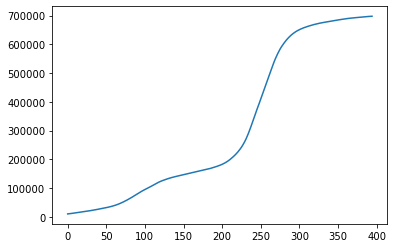

In [7]:
#obtain Infected data

ages = ['0-17', '18-49', '50-64', '65+']

Inf = dict()
for i in ages:
    age_group = age_df[age_df['demographic_value'] == i]
    Ii = []
    
    #first day
    Ii.append(age_group['total_cases'].iloc[0])
    
    #for first day 1-7, do average of its neighbors
    for k in range(1, 7):
        Ii.append(np.mean(age_group['total_cases'].iloc[k-1:k+1]))
    
    #moving average of windows of t = 15
    for k in range(7, len(age_group['total_cases'])-7):
        Ii.append(np.mean(age_group['total_cases'].iloc[k-7:k+7]))
    
    #for last -7 to -1 days do average of its neighbors
    for k in range(len(age_group['total_cases'])-7, len(age_group['total_cases'])-1):
        Ii.append(np.mean(age_group['total_cases'].iloc[k-1:k+1]))
    #for last day, just append the value
    Ii.append(age_group['total_cases'].iloc[Days-1])
    Inf[i] = Ii
plt.plot(range(len(Inf['50-64'])),Inf['50-64'])

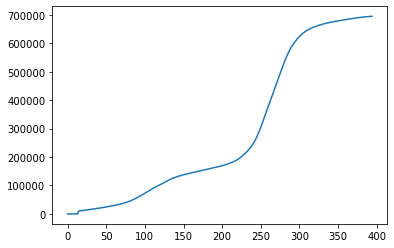

In [8]:
#Obtain Recovered+Death Data
Recovery_days = 14

R_a = dict()
for i in ages:
    Ri = []
    for k in range(0, Recovery_days):
        Ri.append(0)
    
    for k in range(Recovery_days, Days):
        Ri.append(Inf[i][k-Recovery_days])
    R_a[i] = Ri
#plt.plot(range(len(R_a['0-17'])),R_a['0-17'])
#plt.plot(range(len(R_a['18-49'])),R_a['18-49'])
plt.plot(range(len(R_a['50-64'])),R_a['50-64'])
#plt.plot(range(len(R_a['65+'])),R_a['65+'])

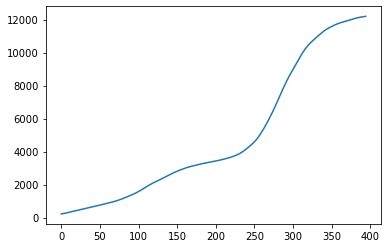

In [9]:
#obtain Death data

ages = ['0-17', '18-49', '50-64', '65+']

D = dict()
for i in ages:
    age_group = age_df[age_df['demographic_value'] == i]
    Di = []
    
    #first day
    Di.append(age_group['deaths'].iloc[0])
    
    #for first day 1-7, do average of its neighbors
    for k in range(1, 7):
        Di.append(np.mean(age_group['deaths'].iloc[k-1:k+1]))
    
    #moving average of windows of t = 15
    for k in range(7, len(age_group['deaths'])-7):
        Di.append(np.mean(age_group['deaths'].iloc[k-7:k+7]))
    
    #for last -7 to -1 days do average of its neighbors
    for k in range(len(age_group['deaths'])-7, len(age_group['deaths'])-1):
        Di.append(np.mean(age_group['deaths'].iloc[k-1:k+1]))
    #for last day, just append the value
    Di.append(age_group['deaths'].iloc[Days-1])
    D[i] = Di
#plt.plot(range(len(D['0-17'])),D['0-17'])
#plt.plot(range(len(D['18-49'])),D['18-49'])
plt.plot(range(len(D['50-64'])),D['50-64'])
#plt.plot(range(len(D['65+'])),D['65+'])

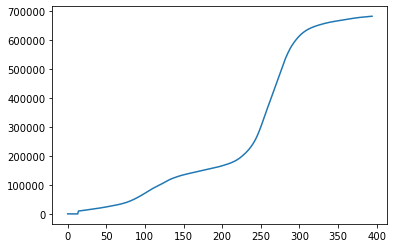

In [10]:
#Obtain Recovered Data
R = dict()
for i in ages:
    Ri = []
    for k in range(0, Days):
        Ri.append(R_a[i][k]-D[i][k])
    R[i] = Ri
#plt.plot(range(len(R['0-17'])),R['0-17'])
#plt.plot(range(len(R['18-49'])),R['18-49'])
plt.plot(range(len(R['50-64'])),R['50-64'])
#plt.plot(range(len(R['65+'])),R['65+'])

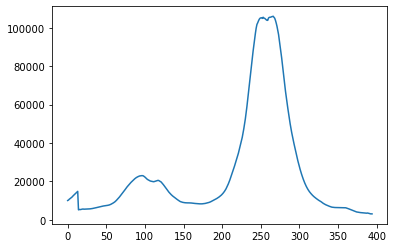

In [11]:
#Obtain infectious Data
I = dict()
for i in ages:
    Ii = []
    for k in range(0, Days):
        Ii.append(Inf[i][k]-R_a[i][k])
    I[i] = Ii
#plt.plot(range(len(I['0-17'])),I['0-17'])
#plt.plot(range(len(I['18-49'])),I['18-49'])
plt.plot(range(len(I['50-64'])),I['50-64'])
#plt.plot(range(len(I['65+'])),I['65+'])

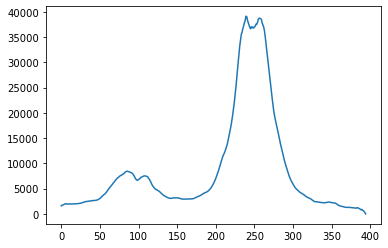

In [12]:
#Obtain Exposed Data
incubation_days = 5

E = dict()
for i in ages:
    Ei = []
    for k in range(0, Days-incubation_days):
        Ei.append(Inf[i][k+incubation_days]-Inf[i][k])
    
    for k in range(Days-incubation_days, Days):
        Ei.append(Inf[i][Days-1]-Inf[i][k])
    E[i] = Ei
#plt.plot(range(len(E['0-17'])),E['0-17'])
#plt.plot(range(len(E['18-49'])),E['18-49'])
plt.plot(range(len(E['50-64'])),E['50-64'])
#plt.plot(range(len(E['65+'])),E['65+'])

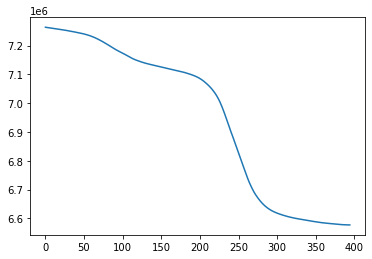

In [13]:
#obtain Susceptible data
percentages = age_df['percent_of_ca_population'].unique()
age_pop = dict(zip(ages, percentages))

S = dict()
for age in ages:
    Si = []
    for i, j, k, m in zip(E[age], I[age], R[age], D[age]):
        Si.append(age_pop[age]*Population/100-i-j-k-m)
    S[age] = Si
plt.plot(range(len(S['50-64'])),S['50-64'])

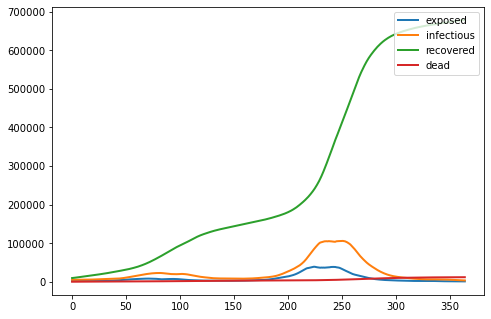

In [14]:
#truncate sequences and plot SEIR from data

for i in ages:
    S[i] = S[i][15:Days-15]
    E[i] = E[i][15:Days-15]
    I[i] = I[i][15:Days-15]
    R[i] = R[i][15:Days-15]
    D[i] = D[i][15:Days-15]
Days = Days-30

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#ax.plot(range(len(S['50-64'])),S['50-64'],lw=2,label='suceptible')
ax.plot(range(Days),E['50-64'],lw=2,label='exposed')
ax.plot(range(Days),I['50-64'],lw=2,label='infectious')
ax.plot(range(Days),R['50-64'],lw=2,label='recovered')
ax.plot(range(Days),D['50-64'],lw=2,label='dead')
#ax.set_ylabel(‘Price’,fontsize=20)
plt.legend(loc='upper right')

In [15]:
ages = ['0-17', '18-49', '50-64', '65+']
labels = ['1','2','3','4']
for i in range(0,4):
    vars()['S_'+labels[i]] = S[ages[i]]
    vars()['E_'+labels[i]] = E[ages[i]]
    vars()['I_'+labels[i]] = I[ages[i]]
    vars()['R_'+labels[i]] = R[ages[i]]
    vars()['D_'+labels[i]] = D[ages[i]]
    
N = []
for k in range(0, Days):
    Ni = 0
    for i in ages:
        Ni = Ni + S[i][k]+E[i][k]+I[i][k]+R[i][k]
    N.append(Ni)
#plt.plot(range(len(N)),N)

epsilon = 1/5 # Rate of progression from exposed to infectious (the reciprocal is the incubation period)
gamma = 1/14 # Recovery rate of infectious individuals (the reciprocal is the infectious period)    

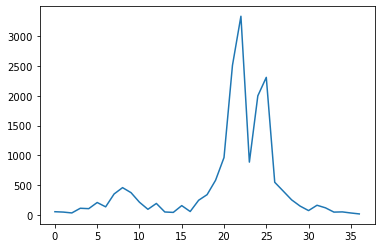

In [16]:
error = []
segment_size = 10
A_1 = np.ndarray(shape=(0,4))
for i in range(0,Days-1,segment_size):
    C_1 = np.ndarray(shape=(0,4))
    d_1 = np.ndarray(shape=(0,1))
    for t in range(i, i+segment_size):
        if(t<Days-1):
            c = [[-S_1[t]*I_1[t]/N[t], -S_1[t]*I_2[t]/N[t], -S_1[t]*I_3[t]/N[t], -S_1[t]*I_4[t]/N[t]],
                [S_1[t]*I_1[t]/N[t], S_1[t]*I_2[t]/N[t], S_1[t]*I_3[t]/N[t], S_1[t]*I_4[t]/N[t]]]
            C_1=np.append(C_1,c,axis = 0)

            partial_d = [[S_1[t+1]-S_1[t]], [E_1[t+1]-E_1[t]+epsilon*E_1[t]]]
            d_1=np.append(d_1,partial_d,axis = 0)
    d_1=np.squeeze(d_1)
    x = np.ndarray(shape=(1,4))
    error.append(nnls(C_1, d_1)[1])
    #x[0] = lsq_linear(C_1, d_1, tol = 10E-10, max_iter = 1000, lsq_solver = 'exact', bounds=(0, np.inf))['x']
    x[0] = nnls(C_1, d_1)[0]
    A_1 = np.append(A_1,x,axis = 0)
#print(A_1)

alpha_1 = np.ndarray(shape=(1,1))
C_1 = np.ndarray(shape=(0,1))
d_1 = np.ndarray(shape=(0,1))
for t in range(0,Days-1):
    c = [[-I_1[t]],[I_1[t]]]
    C_1=np.append(C_1,c,axis = 0)
    d = [[I_1[t+1]-I_1[t]-epsilon*E_1[t]+gamma*I_1[t]],[D_1[t+1]-D_1[t]]]
    d_1=np.append(d_1,d,axis = 0)
d_1=np.squeeze(d_1)
alpha_1[0] = lsq_linear(C_1, d_1, tol = 10E-10, max_iter = 1000, lsq_solver = 'exact', bounds=(0, np.inf))['x']
#print(alpha_1)

#print("===============================================")
A_2 = np.ndarray(shape=(0,4))
for i in range(0,Days-1,segment_size):
    C_1 = np.ndarray(shape=(0,4))
    d_1 = np.ndarray(shape=(0,1))
    for t in range(i, i+segment_size):
        if(t<Days-1):
            c = [[-S_2[t]*I_1[t]/N[t], -S_2[t]*I_2[t]/N[t], -S_2[t]*I_3[t]/N[t], -S_2[t]*I_4[t]/N[t]],
                [S_2[t]*I_1[t]/N[t], S_2[t]*I_2[t]/N[t], S_2[t]*I_3[t]/N[t], S_2[t]*I_4[t]/N[t]]]
            C_1=np.append(C_1,c,axis = 0)

            partial_d = [[S_2[t+1]-S_2[t]], [E_2[t+1]-E_2[t]+epsilon*E_2[t]]]
            d_1=np.append(d_1,partial_d,axis = 0)
    d_1=np.squeeze(d_1)
    x = np.ndarray(shape=(1,4))
    #x[0] = lsq_linear(C_1, d_1, tol = 10E-10, max_iter = 1000, lsq_solver = 'exact', bounds=(0, np.inf))['x']
    x[0] = nnls(C_1, d_1)[0]
    A_2 = np.append(A_2,x,axis = 0)
#print(A_2)

alpha_2 = np.ndarray(shape=(1,1))
C_1 = np.ndarray(shape=(0,1))
d_1 = np.ndarray(shape=(0,1))
for t in range(0,Days-1):
    c = [[-I_2[t]],[I_2[t]]]
    C_1=np.append(C_1,c,axis = 0)
    d = [[I_2[t+1]-I_2[t]-epsilon*E_2[t]+gamma*I_2[t]],[D_2[t+1]-D_2[t]]]
    d_1=np.append(d_1,d,axis = 0)
d_1=np.squeeze(d_1)
x = np.ndarray(shape=(1,1))
alpha_2[0] = lsq_linear(C_1, d_1, tol = 10E-10,max_iter = 1000, lsq_solver = 'exact', bounds=(0, np.inf))['x']
#print(alpha_2)

#print("===============================================")
A_3 = np.ndarray(shape=(0,4))
for i in range(0,Days-1,segment_size):
    C_1 = np.ndarray(shape=(0,4))
    d_1 = np.ndarray(shape=(0,1))
    for t in range(i, i+segment_size):
        if(t<Days-1):
            c = [[-S_3[t]*I_1[t]/N[t], -S_3[t]*I_2[t]/N[t], -S_3[t]*I_3[t]/N[t], -S_3[t]*I_4[t]/N[t]],
                [S_3[t]*I_1[t]/N[t], S_3[t]*I_2[t]/N[t], S_3[t]*I_3[t]/N[t], S_3[t]*I_4[t]/N[t]]]
            C_1=np.append(C_1,c,axis = 0)

            partial_d = [[S_3[t+1]-S_3[t]], [E_3[t+1]-E_3[t]+epsilon*E_3[t]]]
            d_1=np.append(d_1,partial_d,axis = 0)
    d_1=np.squeeze(d_1)
    x = np.ndarray(shape=(1,4))
    #x[0] = lsq_linear(C_1, d_1,  tol = 10E-10, max_iter = 1000,lsq_solver = 'exact', bounds=(0, np.inf))['x']
    x[0] = nnls(C_1, d_1)[0]
    A_3 = np.append(A_3,x,axis = 0)
#print(A_3)

alpha_3 = np.ndarray(shape=(1,1))
C_1 = np.ndarray(shape=(0,1))
d_1 = np.ndarray(shape=(0,1))
for t in range(0,Days-1):
    c = [[-I_3[t]],[I_3[t]]]
    C_1=np.append(C_1,c,axis = 0)
    d = [[I_3[t+1]-I_3[t]-epsilon*E_3[t]+gamma*I_3[t]],[D_3[t+1]-D_3[t]]]
    d_1=np.append(d_1,d,axis = 0)
d_1=np.squeeze(d_1)
x = np.ndarray(shape=(1,1))
alpha_3[0] = lsq_linear(C_1, d_1, tol = 10E-10,max_iter = 1000, lsq_solver = 'exact', bounds=(0, np.inf))['x']
#print(alpha_3)

#print("===============================================")
A_4 = np.ndarray(shape=(0,4))
for i in range(0,Days-1,segment_size):
    C_1 = np.ndarray(shape=(0,4))
    d_1 = np.ndarray(shape=(0,1))
    for t in range(i, i+segment_size):
        if(t<Days-1):
            c = [[-S_4[t]*I_1[t]/N[t], -S_4[t]*I_2[t]/N[t], -S_4[t]*I_3[t]/N[t], -S_4[t]*I_4[t]/N[t]],
                [S_4[t]*I_1[t]/N[t], S_4[t]*I_2[t]/N[t], S_4[t]*I_3[t]/N[t], S_4[t]*I_4[t]/N[t]]]
            C_1=np.append(C_1,c,axis = 0)

            partial_d = [[S_4[t+1]-S_4[t]], [E_4[t+1]-E_4[t]+epsilon*E_4[t]]]
            d_1=np.append(d_1,partial_d,axis = 0)
    d_1=np.squeeze(d_1)
    x = np.ndarray(shape=(1,4))
    x[0] = lsq_linear(C_1, d_1, tol = 10E-10,max_iter = 1000, lsq_solver = 'exact', bounds=(0, np.inf))['x']
    #x[0] = nnls(C_1, d_1)[0]
    A_4 = np.append(A_4,x,axis = 0)
#print(A_4)

alpha_4 = np.ndarray(shape=(1,1))
C_1 = np.ndarray(shape=(0,1))
d_1 = np.ndarray(shape=(0,1))
for t in range(0,Days-1):
    c = [[-I_4[t]],[I_4[t]]]
    C_1=np.append(C_1,c,axis = 0)
    d = [[I_4[t+1]-I_4[t]-epsilon*E_4[t]+gamma*I_4[t]],[D_4[t+1]-D_4[t]]]
    d_1=np.append(d_1,d,axis = 0)
d_1=np.squeeze(d_1)
x = np.ndarray(shape=(1,1))
alpha_4[0] = lsq_linear(C_1, d_1, tol = 10E-10,max_iter = 1000,lsq_solver = 'exact', bounds=(0, np.inf))['x']
#print(alpha_4)

plt.plot(error)

In [17]:
#Get A matrix and Alpha vector from simulations
#adding some amount of positive noise to A seems to mask the artifacts of least-squares problem solution
Alpha = np.ndarray(shape=(4,1))
Alpha[0] = alpha_1
Alpha[1] = alpha_2
Alpha[2] = alpha_3
Alpha[3] = alpha_4
A = np.ndarray(shape=(A_1.shape[0],4,4))
for i in range(A_1.shape[0]):
    A[i][0] = A_1[i]
    A[i][1] = A_2[i]
    A[i][2] = A_3[i]
    A[i][3] = A_4[i]
print(Alpha)
print(A[0])
A_noise = np.random.rand(A.shape[0],A.shape[1],A.shape[2]) * 0.5 * 10E-3
#A = A + A_noise
print(A[0])

[[3.59126626e-20]
 [7.28086411e-19]
 [6.61598699e-20]
 [2.30527902e-03]]
[[5.11364684e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.26465871e-01 1.01958258e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.69350915e-01 0.00000000e+00 2.38692890e-02]
 [7.43512371e-14 9.67219508e-15 5.07437612e-17 4.04587913e-01]]
[[5.11364684e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.26465871e-01 1.01958258e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.69350915e-01 0.00000000e+00 2.38692890e-02]
 [7.43512371e-14 9.67219508e-15 5.07437612e-17 4.04587913e-01]]


Total SEIRD simulation


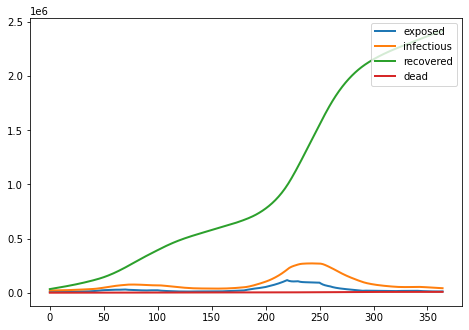

In [18]:
#run SEIR simulation from estimated parameters

groups = 4
Ss = np.zeros((Days,groups))
Es = np.zeros((Days,groups))
Is = np.zeros((Days,groups))
Rs = np.zeros((Days,groups))
Ds = np.zeros((Days,groups))

for i in range(4):
    Ss[0][i]=S[ages[i]][0]            # initial susceptible populatioon
    Es[0][i]=E[ages[i]][0]                # initial exposed
    Is[0][i]=I[ages[i]][0]               # initial infected
    Rs[0][i]=R[ages[i]][0]
    Ds[0][i]=D[ages[i]][0]

segment = -1
for i in range(0,Days-1):
    N = sum(Ss[i])+sum(Es[i])+sum(Is[i])+sum(Rs[i])

    if(i%segment_size == 0):
        segment = segment+1
    for j in range(0,groups):

        Ss[i+1][j] = Ss[i][j] - sum(np.multiply(A[segment][j],Is[i])*Ss[i][j])/N
        Es[i+1][j] = Es[i][j] + sum(np.multiply(A[segment][j],Is[i])*Ss[i][j])/N - epsilon*Es[i][j]
        Is[i+1][j] = Is[i][j] + epsilon*Es[i][j] - (Alpha[j]+gamma)*Is[i][j]
        Rs[i+1][j] = Rs[i][j] + gamma*Is[i][j]
        Ds[i+1][j] = Ds[i][j] + Alpha[j]*Is[i][j]
        #dI[i] = epsilon*E[i]
        #dD[i] = D[i+1] - D[i]

S1 = np.zeros((Days,1))
E1 = np.zeros((Days,1))
I1 = np.zeros((Days,1))
R1 = np.zeros((Days,1))
D1 = np.zeros((Days,1))

for i in range(0,Days):
    S1[i] = sum(Ss[i])
    E1[i] = sum(Es[i])
    I1[i] = sum(Is[i])
    R1[i] = sum(Rs[i])
    D1[i] = sum(Ds[i])

print("Total SEIRD simulation")
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#ax.plot(S1,lw=3,label='suceptible')
ax.plot(E1,lw=2,label='exposed')
ax.plot(I1,lw=2,label='infectious')
ax.plot(R1,lw=2,label='recovered')
ax.plot(D1,lw=2,label='dead')
#ax.set_ylabel(‘Price’,fontsize=20)
plt.legend(loc='upper right')

0-17 age group EIRD


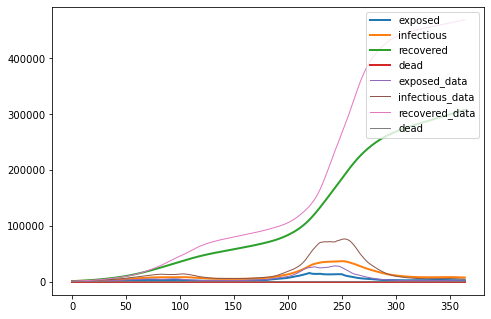

In [19]:
print("0-17 age group EIRD")
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#ax.plot(Ss[:,0],lw=2,label='suceptible')
ax.plot(Es[:,0],lw=2,label='exposed')
ax.plot(Is[:,0],lw=2,label='infectious')
ax.plot(Rs[:,0],lw=2,label='recovered')
ax.plot(Ds[:,0],lw=2,label='dead')
ax.plot(E[ages[0]],lw=1,label='exposed_data')
ax.plot(I[ages[0]],lw=1,label='infectious_data')
ax.plot(R[ages[0]],lw=1,label='recovered_data')
ax.plot(D[ages[0]],lw=1,label='dead')

#ax.set_ylabel(‘Price’,fontsize=20)
plt.legend(loc='upper right')

18-49 age group EIRD


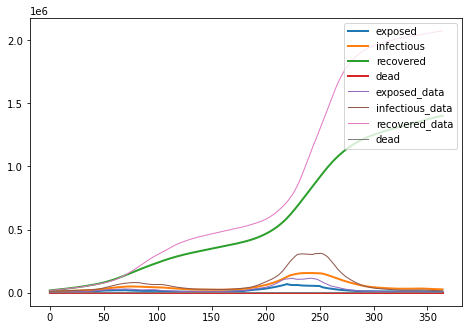

In [20]:
print("18-49 age group EIRD")
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#ax.plot(Ss[:,1],lw=2,label='suceptible')
ax.plot(Es[:,1],lw=2,label='exposed')
ax.plot(Is[:,1],lw=2,label='infectious')
ax.plot(Rs[:,1],lw=2,label='recovered')
ax.plot(Ds[:,1],lw=2,label='dead')
ax.plot(E[ages[1]],lw=1,label='exposed_data')
ax.plot(I[ages[1]],lw=1,label='infectious_data')
ax.plot(R[ages[1]],lw=1,label='recovered_data')
ax.plot(D[ages[1]],lw=1,label='dead')


#ax.set_ylabel(‘Price’,fontsize=20)
plt.legend(loc='upper right')

50-64 age group EIRD


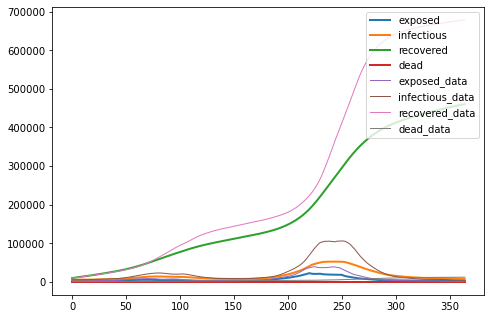

In [21]:
print("50-64 age group EIRD")
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#ax.plot(Ss[:,2],lw=2,label='suceptible')
ax.plot(Es[:,2],lw=2,label='exposed')
ax.plot(Is[:,2],lw=2,label='infectious')
ax.plot(Rs[:,2],lw=2,label='recovered')
ax.plot(Ds[:,2],lw=2,label='dead')
#ax.plot(S[ages[2]],lw=1,label='suceptible_data')
ax.plot(E[ages[2]],lw=1,label='exposed_data')
ax.plot(I[ages[2]],lw=1,label='infectious_data')
ax.plot(R[ages[2]],lw=1,label='recovered_data')
ax.plot(D[ages[2]],lw=1,label='dead_data')

#ax.set_ylabel(‘Price’,fontsize=20)
plt.legend(loc='upper right')

65+ age group EIRD


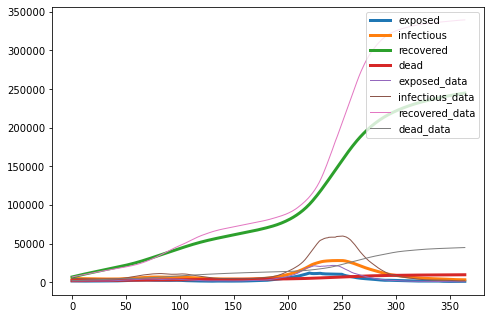

In [22]:
print("65+ age group EIRD")
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#ax.plot(Ss[:,3],lw=3,label='suceptible')
ax.plot(Es[:,3],lw=3,label='exposed')
ax.plot(Is[:,3],lw=3,label='infectious')
ax.plot(Rs[:,3],lw=3,label='recovered')
ax.plot(Ds[:,3],lw=3,label='dead')

ax.plot(E[ages[3]],lw=1,label='exposed_data')
ax.plot(I[ages[3]],lw=1,label='infectious_data')
ax.plot(R[ages[3]],lw=1,label='recovered_data')
ax.plot(D[ages[3]],lw=1,label='dead_data')

#ax.set_ylabel(‘Price’,fontsize=20)
plt.legend(loc='upper right')
